<a href="https://colab.research.google.com/github/taareek/stock-price/blob/main/stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is implemented from the following blog:<br>
https://www.datacamp.com/tutorial/lstm-python-stock-market?fbclid=IwAR3h7ogDM5NK9VejH3CIGg6uGG6_eP5CDeGKa6FWfVafIDIoW4mD9SD_SPg <br>
This blog is about stock price prediction using LSTM

In [ ]:
# Make sure that you have all these libaries available to run the code successfully
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# for pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [ ]:
# installing alpha vantage to get financial data
!pip install alpha_vantage

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 18.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data Loading and EDA

In [ ]:
# data_source = 'kaggle' # alphavantage or kaggle
# I am using data from alpha vantage
data_source = 'alphavantage'

if data_source == 'alphavantage':
    # ====================== Loading Data from Alpha Vantage ==================================

    api_key = '7NQV86QFFWOGR22F'

    # American Airlines stock market prices
    ticker = "AAL"

    # JSON file with all the stock market data for AAL from the last 20 years
    # Here, I have taken daily adjusted data, symbol= data from specific organization, ouputsize= full(20+yrs)/compact(100)
    url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=%s&outputsize=full&apikey=%s"%(ticker,api_key)

    # Save data to this file
    file_to_save = '/content/drive/MyDrive/Colab Notebooks/stock_market_data_-%s.csv'%ticker

    # If you haven't already saved data,
    # Go ahead and grab the data from the url
    # And store date, low, high, volume, close, open values to a Pandas DataFrame
    if not os.path.exists(file_to_save):
        with urllib.request.urlopen(url_string) as url:
            data = json.loads(url.read().decode())
            print(data)
            # extract stock market data
            data = data['Time Series (Daily)']
            df = pd.DataFrame(columns=['Date','Low','High','Close','Open'])
            for k,v in data.items():
                date = dt.datetime.strptime(k, '%Y-%m-%d')
                data_row = [date.date(),float(v['3. low']),float(v['2. high']),
                            float(v['4. close']),float(v['1. open'])]
                df.loc[-1,:] = data_row
                df.index = df.index + 1
        print('Data saved to : %s'%file_to_save)
        print('Downloaded from Alpha Vantage')
        df.to_csv(file_to_save)

    # If the data is already there, just load it from the CSV
    else:
        print('File already exists. Loading data from CSV')
        df = pd.read_csv(file_to_save)

else:

    # ====================== Loading Data from Kaggle ==================================
    # You will be using HP's data. Feel free to experiment with other data.
    # But while doing so, be careful to have a large enough dataset and also pay attention to the data normalization
    df = pd.read_csv(os.path.join('Stocks','hpq.us.txt'),delimiter=',',usecols=['Date','Open','High','Low','Close'])
    print('Loaded data from the Kaggle repository')


File already exists. Loading data from CSV


In [ ]:
# Sort DataFrame by date
df = df.sort_values('Date')

# Double check the result
df.head()

,Unnamed: 0,Date,Low,High,Close,Open
4458,0,2005-09-27,19.10,21.40,19.30,21.05
4457,1,2005-09-28,19.20,20.53,20.50,19.30
4456,2,2005-09-29,20.10,20.58,20.21,20.40
4455,3,2005-09-30,20.18,21.05,21.01,20.26
4454,4,2005-10-03,20.90,21.75,21.50,20.90


In [ ]:
len(df)

4459

**Data Visualization**

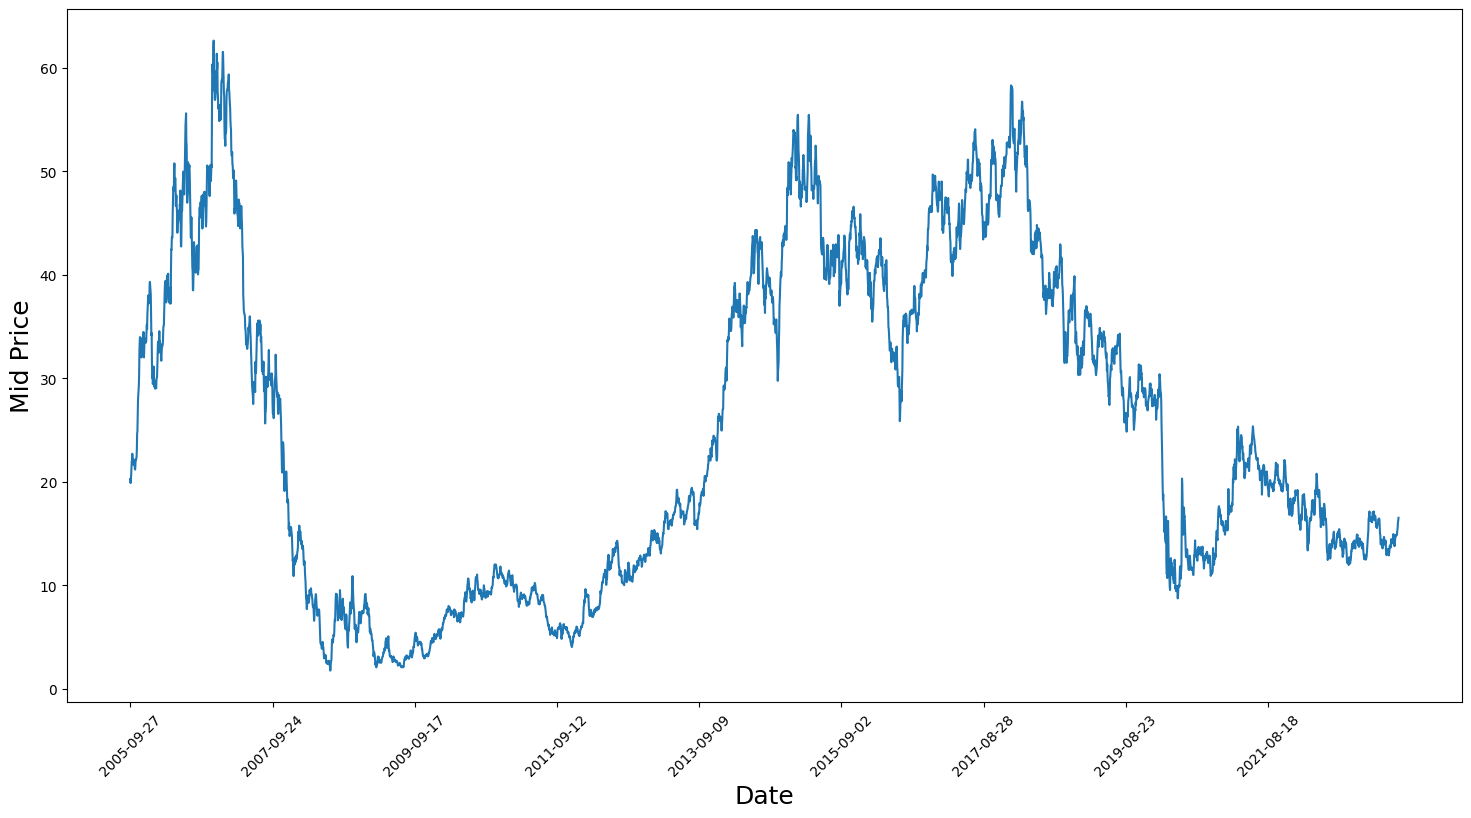

In [ ]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

In [ ]:
# data splitting
# First calculate the mid prices from the highest and lowest
# high_prices = df.loc[:,'High'].as_matrix()
# low_prices = df.loc[:,'Low'].as_matrix()
# mid_prices = (high_prices+low_prices)/2.0
# df.as_matrix() depriocated since version 0.23.0: Use DataFrame.values instead.
high_prices = df.loc[:,'High'].values
low_prices = df.loc[:,'Low'].values
mid_prices = (high_prices+low_prices)/2.0

In [ ]:
type(df)

pandas.core.frame.DataFrame

In [ ]:
mid_prices

array([20.25  , 19.865 , 20.34  , ..., 16.05  , 16.225 , 16.5075])

In [ ]:
# we have total 4459 days data, we will take 4000 as train data and 459 as test data
train_data = mid_prices[:4000]
test_data = mid_prices[4000:]

In [ ]:
# Scale the data to be between 0 and 1
# When scaling remember! You normalize both test and train data with respect to training data
# Because you are not supposed to have access to test data
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [ ]:
# Train the Scaler with training data and smooth data
smoothing_window_size = 1000
for di in range(0,4000,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
# scaler.fit(train_data[di+smoothing_window_size:,:])
# train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

In [ ]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)

print("train data shape: ", train_data.shape)
print("test data shape: ", test_data.shape)

train data shape:  (4000,)
test data shape:  (459,)


### Prediction via averaging

You can now smooth the data using the exponential moving average. This helps you to get rid of the inherent raggedness of the data in stock prices and produce a smoother curve.

Note that you should only smooth training data.

In [ ]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(4000):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)
print("shape of all mild data: ", all_mid_data.shape)

shape of all mild data:  (4459,)


In [ ]:
window_size = 100
N = train_data.size
print(N)
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Date']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))


4000
MSE error for standard averaging: 0.00708


4459


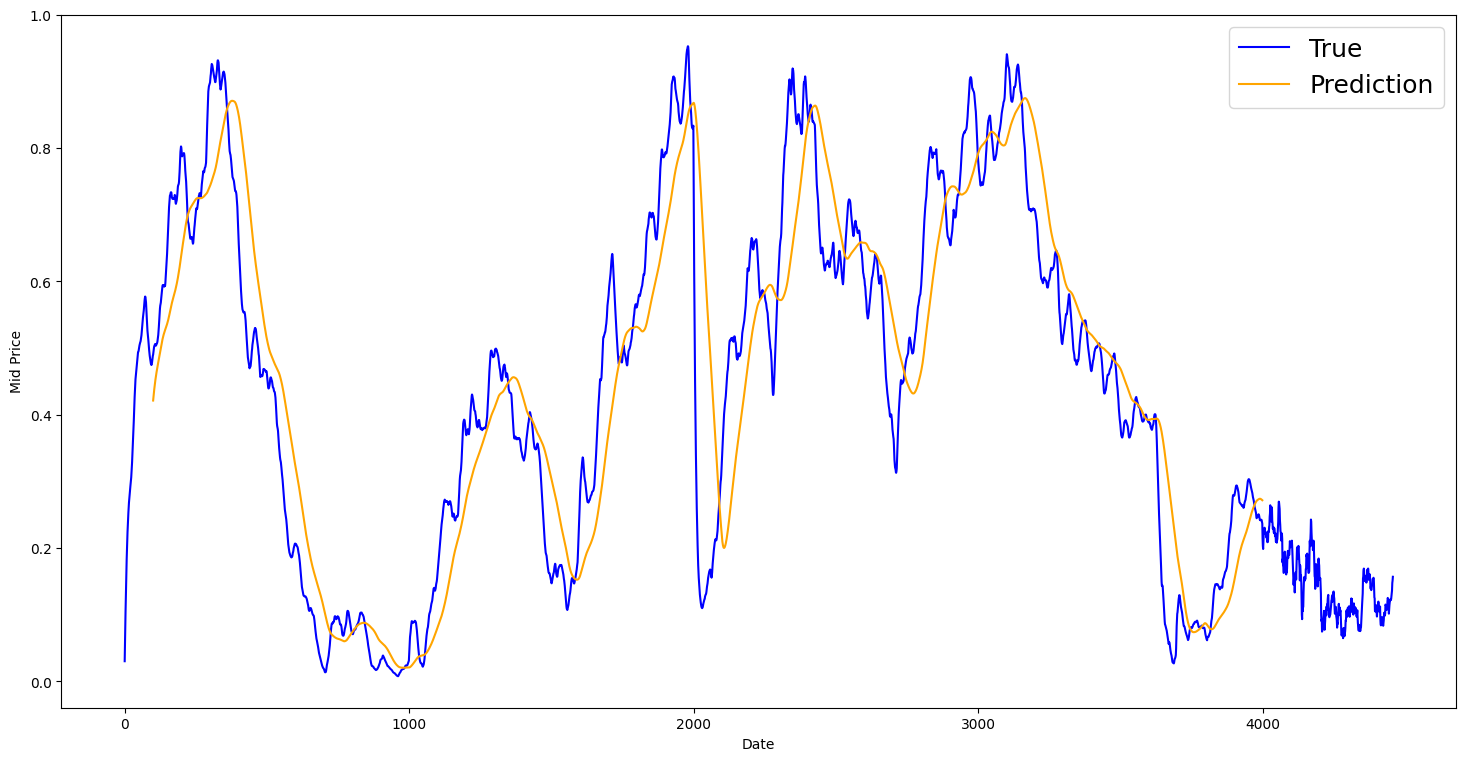

In [ ]:
print(df.shape[0])
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()


###Exponential Moving Average

In [ ]:
window_size = 10
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.2

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))


MSE error for EMA averaging: 0.00002


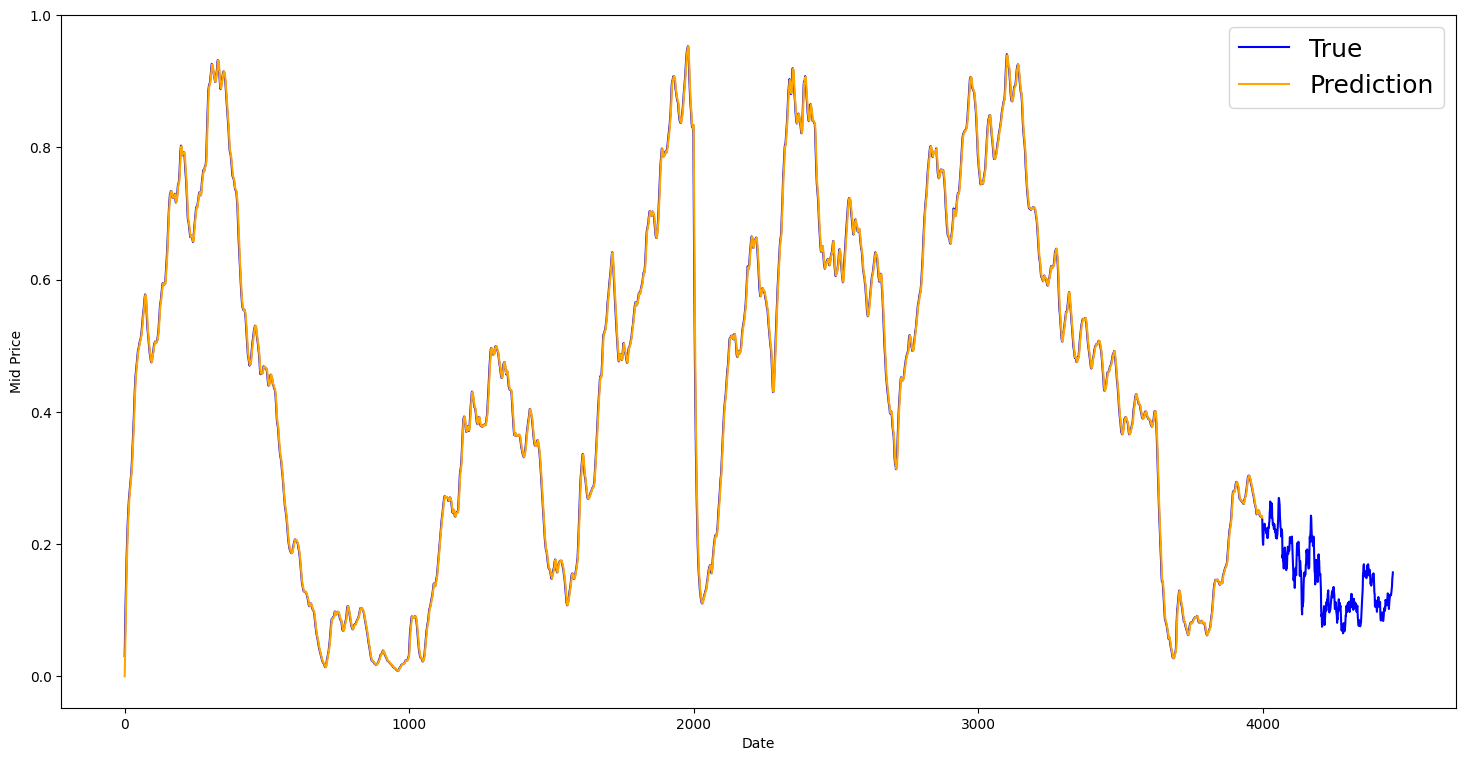

In [ ]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()


### Implement Using LSTM (Pytorch)

Understanding [LSTM](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) <br>
In this section, Initially I will be using IBM's 20 years historical data and predict via LSTM. After that, I will also train above  American Airlines stock (AAL) data to compare with Exponential Moving Average technique.

In [ ]:
# importing necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from alpha_vantage.timeseries import TimeSeries

In [ ]:
# defining a JSON named config to store initial information
config = {
    "alpha_vantage": {
        "key": "7NQV86QFFWOGR22F", # you can use the demo API key for this project, but please make sure to get your own API key at https://www.alphavantage.co/support/#api-key
        "symbol": "IBM",
        "outputsize": "full",
        "key_adjusted_close": "5. adjusted close",  # in the downloaded data close values are written in this way
    },
    "data": {
        "window_size": 20,
        "train_split_size": 0.80,
    },
    "plots": {
        "xticks_interval": 90, # show a date every 90 days
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 1, # since we are only using 1 feature, close price
        "num_lstm_layers": 2,
        "lstm_size": 32,
        "dropout": 0.2,
    },
    "training": {
        "device": "cpu", # "cuda" or "cpu"
        "batch_size": 64,
        "num_epoch": 100,
        "learning_rate": 0.01,
        "scheduler_step_size": 40,
    }
}

In [ ]:
ts = TimeSeries(key='7NQV86QFFWOGR22F')
data, meta_data = ts.get_daily_adjusted(config["alpha_vantage"]["symbol"], outputsize=config["alpha_vantage"]["outputsize"])

In [ ]:
print(type(data))

<class 'dict'>


In [ ]:
# we can see a daily data that contains following values
data['2020-11-20']

{'1. open': '117.6',
 '2. high': '118.04',
 '3. low': '116.69',
 '4. close': '116.94',
 '5. adjusted close': '98.7227833992276',
 '6. volume': '5024593',
 '7. dividend amount': '0.0000',
 '8. split coefficient': '1.0'}

In [ ]:
meta_data

{'1. Information': 'Daily Time Series with Splits and Dividend Events',
 '2. Symbol': 'IBM',
 '3. Last Refreshed': '2023-06-16',
 '4. Output Size': 'Full size',
 '5. Time Zone': 'US/Eastern'}

Number data points 5945 from 1999-11-01 to 2023-06-16


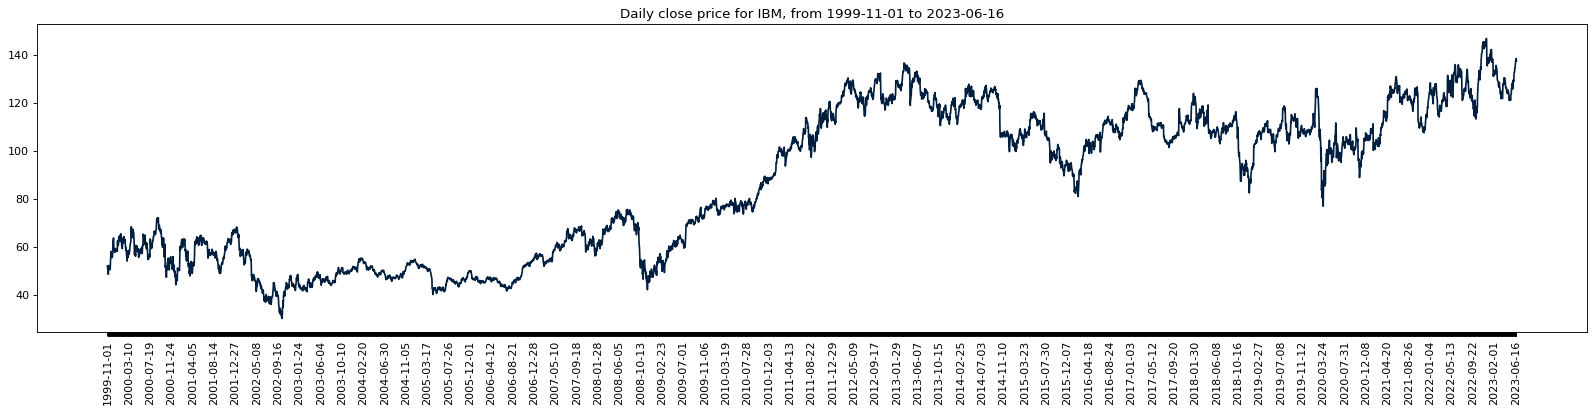

In [ ]:
# documentation: https://alpha-vantage.readthedocs.io/en/latest/#usage-example

# function to download data form alpha vantage
def download_data(config):
    ts = TimeSeries(key='7NQV86QFFWOGR22F')
    data, meta_data = ts.get_daily_adjusted(config["alpha_vantage"]["symbol"], outputsize=config["alpha_vantage"]["outputsize"])

    data_date = [date for date in data.keys()]
    data_date.reverse()

    # we will be taking only closing price
    data_close_price = [float(data[date][config["alpha_vantage"]["key_adjusted_close"]]) for date in data.keys()]
    data_close_price.reverse()
    data_close_price = np.array(data_close_price)

    # total data contains in our dataset
    num_data_points = len(data_date)
    # time length of data
    display_date_range = "from " + data_date[0] + " to " + data_date[num_data_points-1]
    print("Number data points", num_data_points, display_date_range)

    return data_date, data_close_price, num_data_points, display_date_range

# getting the data
data_date, data_close_price, num_data_points, display_date_range = download_data(config)

# plot

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_date, data_close_price, color=config["plots"]["color_actual"])
xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
x = np.arange(0,len(xticks))
plt.xticks(x, xticks, rotation='vertical')
plt.title("Daily close price for " + config["alpha_vantage"]["symbol"] + ", " + display_date_range)
# plt.grid(b=None, which='major', axis='y', linestyle='--')
plt.show()

In [ ]:
print(f"Minimum close price: {data_close_price.min()}")
print(f"Maximum close price: {data_close_price.max()}")

Minimum close price: 30.047141124938
Maximum close price: 146.725038717934


In [ ]:
# Before train the data, we will perform Normalization.
# we will be using mean and standard deviation from close data to perform Normalization
# After transformation the data will have a mean of 0 and the standard deviation is 1
class Normalizer():
    def __init__(self):
        self.mu = None
        self.sd = None

    def fit_transform(self, x):
        self.mu = np.mean(x, axis=(0), keepdims=True)
        self.sd = np.std(x, axis=(0), keepdims=True)
        normalized_x = (x - self.mu)/self.sd
        return normalized_x

    def inverse_transform(self, x):
        return (x*self.sd) + self.mu

# normalize
scaler = Normalizer()
normalized_data_close_price = scaler.fit_transform(data_close_price)

In [ ]:
print(f"Minimum close price after Normalization: {normalized_data_close_price.min()}")
print(f"Maximum close price after Normalization: {normalized_data_close_price.max()}")

Minimum close price after Normalization: -1.8475463686023206
Maximum close price after Normalization: 1.9683755177817484


In [ ]:
print("Shape of normalized close price: ", normalized_data_close_price.shape)

Shape of normalized close price:  (5945,)


**Data generation: training and validation data**

In this project, we will train the model to predict the 21st day's close price based on the past 20 days' close prices. The number of days, 20, was selected based on a few reasons:


*   When LSTM models are used in natural language processing, the number of words in a sentence typically ranges from 15 to 20 words
*   Gradient descent considerations: attempting to back-propagate across very long input sequences may result in vanishing gradients (more on this later)
*  Longer sequences tend to have much longer training times

After transforming the dataset into input features and output labels, the shape of our X is (5945, 20), with 5388 being the number of rows and each row containing a sequence of past 20 days' prices. The corresponding Y data shape is (5945,), which matches the number of rows in X. But as we are using 20 day's close, the dimension will reduced to (5925, 20).

In [ ]:
# function to preapare data

# input data that will be containting historical 20 day's data
def prepare_data_x(x, window_size):
    # perform windowing
    n_row = x.shape[0] - window_size + 1
    output = np.lib.stride_tricks.as_strided(x, shape=(n_row, window_size), strides=(x.strides[0], x.strides[0]))
    return output[:-1], output[-1]


# corresponding label of a training sample(next day price based on previous 20 day's historical data)
def prepare_data_y(x, window_size):
    # # perform simple moving average
    # output = np.convolve(x, np.ones(window_size), 'valid') / window_size

    # use the next day as label
    # as we are taking 20 days historical data, so labels should be started after the 20 samples
    output = x[window_size:]
    return output

In [ ]:
# making sequential data where a sample (chunk) contains 20 days historical close price
# data_x contains all data except the last chunk
# data_x_unseen is the last chunk of our data

data_x, data_x_unseen = prepare_data_x(normalized_data_close_price, window_size=config["data"]["window_size"])
data_y = prepare_data_y(normalized_data_close_price, window_size=config["data"]["window_size"])
print(f"Shape of train data (features/input chunk): {data_x.shape}")
print(f"Shape of train labels: {data_y.shape}")

Shape of train data (features/input chunk): (5925, 20)
Shape of train labels: (5925,)


In [ ]:
# now visualize a single data
data_x[4899]

array([0.71563393, 0.68218955, 0.70271224, 0.69283095, 0.72374166,
       0.73108929, 0.70651274, 0.72323493, 0.7265287 , 0.65710626,
       0.66622746, 0.63987734, 0.63936454, 0.53936882, 0.58782828,
       0.61577581, 0.6537229 , 0.61372461, 0.63423656, 0.66833766])

In [ ]:
# split dataset into training and validation

split_index = int(data_y.shape[0]*config["data"]["train_split_size"])
data_x_train = data_x[:split_index]
data_x_val = data_x[split_index:]
data_y_train = data_y[:split_index]
data_y_val = data_y[split_index:]

print(f"train data shape after spliting: {data_x_train.shape}")
print(f"validation data shape after spliting: {data_x_val.shape}")

train data shape after spliting: (4740, 20)
validation data shape after spliting: (1185, 20)


In [ ]:
# prepare data for plotting

to_plot_data_y_train = np.zeros(num_data_points)
to_plot_data_y_val = np.zeros(num_data_points)

to_plot_data_y_train[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform(data_y_train)
to_plot_data_y_val[split_index+config["data"]["window_size"]:] = scaler.inverse_transform(data_y_val)

to_plot_data_y_train = np.where(to_plot_data_y_train == 0, None, to_plot_data_y_train)
to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)

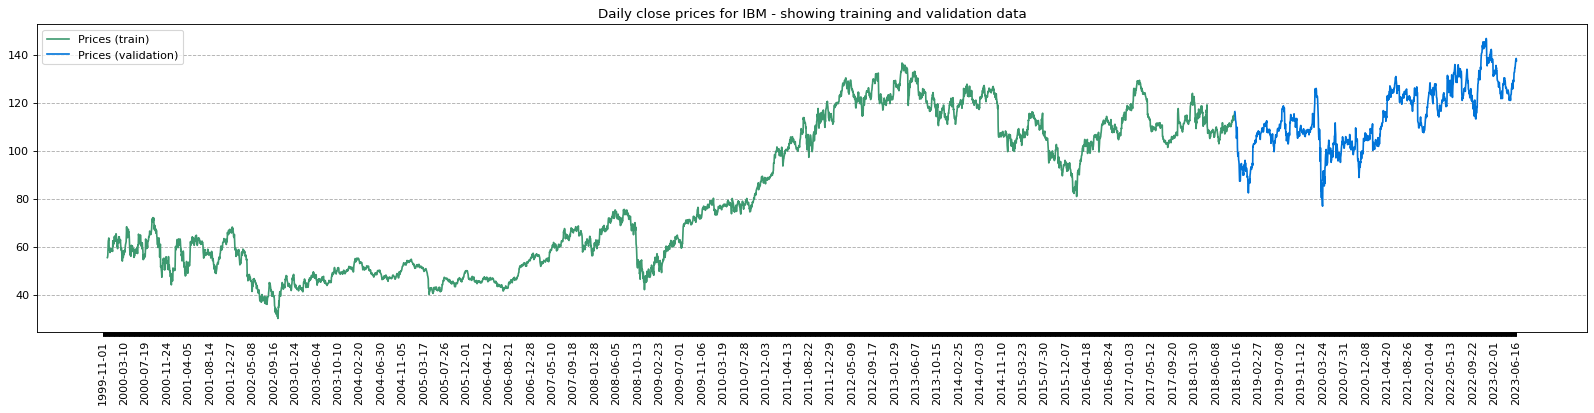

In [ ]:
## plot the data after splitting

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_date, to_plot_data_y_train, label="Prices (train)", color=config["plots"]["color_train"])
plt.plot(data_date, to_plot_data_y_val, label="Prices (validation)", color=config["plots"]["color_val"])
xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
x = np.arange(0,len(xticks))
plt.xticks(x, xticks, rotation='vertical')
plt.title("Daily close prices for " + config["alpha_vantage"]["symbol"] + " - showing training and validation data")
plt.grid(visible=None, which='major', axis='y', linestyle='--')
plt.legend()
plt.show()

In [ ]:
# class to convert our data into Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        x = np.expand_dims(x, 2) # in our case, we have only 1 feature, so we need to convert `x` into [batch, sequence, features] for LSTM
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

In [ ]:
# defining training and validation dataset
dataset_train = TimeSeriesDataset(data_x_train, data_y_train)
dataset_val = TimeSeriesDataset(data_x_val, data_y_val)
print(f"Train dataset shape: {dataset_train.x.shape}, {dataset_train.y.shape}")
print(f"Validation dataset shape: {dataset_val.x.shape}, {dataset_val.y.shape}")

Train dataset shape: (4740, 20, 1), (4740,)
Validation dataset shape: (1185, 20, 1), (1185,)


**Defining LSTM Model**

 With the training and evaluation data now fully normalized and prepared, we are ready to build our LSTM model!

As mentioned before, LSTM is a specialized artificial neural network architecture that can "memorize" patterns from historical sequences of data and extrapolate such patterns for future events. Specifically, it belongs to a group of artificial neural networks called Recurring Neural Networks (RNNs).

LSTM is a popular artificial neural network because it manages to overcome many technical limitations of RNNs. For example, RNNs fail to learn when the data sequence is greater than 5 to 10 due to the vanishing gradients problem, where the gradients are vanishingly small, effectively preventing the model from learning. LSTMs can learn long sequences of data by enforcing constant error flow through self-connected hidden layers, which contain memory cells and corresponding gate units.

Our artificial neural network will have three main layers, with each layer designed with a specific logical purpose:

*   linear layer 1 (linear_1): to map input values into a high dimensional feature space, transforming the features for the LSTM layer
*   LSTM (lstm): to learn the data in sequence
*   linear layer 2 (linear_2): to produce the predicted value based on LSTM's output

We also add Dropout, where randomly selected artificial neurons are ignored during training, therefore regularizing the network to prevent overfitting and improving overall model performance. As an optional step, we also initialize the LSTM's model weights, as some researchers have observed that it could help the model learn more efficiently.



In [ ]:
# defining LSTM Class

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)

        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                 nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                 nn.init.kaiming_normal_(param)  # we can also use different weight initialization
            elif 'weight_hh' in name:
                 nn.init.orthogonal_(param)

    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)

        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # reshape output from hidden cell into [batch, features] for `linear_2`
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1)

        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:,-1]

**Model Training**

In [ ]:
# function to run a epoch
def run_epoch(dataloader, model, optimizer, criterion, scheduler, is_training=False ):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()

        batchsize = x.shape[0]

        x = x.to(config["training"]["device"])
        y = y.to(config["training"]["device"])

        out = model(x)
        loss = criterion(out.contiguous(), y.contiguous())  # contiguous(), it actually makes a copy of the tensor such that the order of its elements in memory is the same as if it had been created from scratch with the same data.

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / batchsize)

    lr = scheduler.get_last_lr()[0]

    return epoch_loss, lr

In [ ]:
# defining data loader
train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=True)

In [ ]:
# defining model, criterion, optimizer and scheduler

model = LSTMModel(input_size=config["model"]["input_size"], hidden_layer_size=config["model"]["lstm_size"],
                  num_layers=config["model"]["num_lstm_layers"], output_size=1,
                  dropout=config["model"]["dropout"])

model = model.to(config["training"]["device"])

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=config["training"]["learning_rate"], betas=(0.9, 0.98), eps=1e-9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config["training"]["scheduler_step_size"], gamma=0.1)

In [ ]:
# training our data with LSTM model for 100 epochs
for epoch in range(config["training"]["num_epoch"]):
    loss_train, lr_train = run_epoch(train_dataloader, model, optimizer, criterion, scheduler, is_training=True)
    loss_val, lr_val = run_epoch(val_dataloader, model, optimizer, criterion, scheduler)
    scheduler.step()

    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f} | lr:{:.6f}'
              .format(epoch+1, config["training"]["num_epoch"], loss_train, loss_val, lr_train))

Epoch[1/100] | loss train:0.052125, test:0.004056 | lr:0.010000
Epoch[2/100] | loss train:0.016087, test:0.001705 | lr:0.010000
Epoch[3/100] | loss train:0.011462, test:0.005686 | lr:0.010000
Epoch[4/100] | loss train:0.012499, test:0.001859 | lr:0.010000
Epoch[5/100] | loss train:0.008616, test:0.003384 | lr:0.010000
Epoch[6/100] | loss train:0.011359, test:0.003507 | lr:0.010000
Epoch[7/100] | loss train:0.008553, test:0.001718 | lr:0.010000
Epoch[8/100] | loss train:0.008144, test:0.001300 | lr:0.010000
Epoch[9/100] | loss train:0.008383, test:0.001685 | lr:0.010000
Epoch[10/100] | loss train:0.008960, test:0.002522 | lr:0.010000
Epoch[11/100] | loss train:0.008178, test:0.001836 | lr:0.010000
Epoch[12/100] | loss train:0.008639, test:0.001385 | lr:0.010000
Epoch[13/100] | loss train:0.007553, test:0.001240 | lr:0.010000
Epoch[14/100] | loss train:0.018477, test:0.001611 | lr:0.010000
Epoch[15/100] | loss train:0.011478, test:0.001833 | lr:0.010000
Epoch[16/100] | loss train:0.00827

**Model Evaluation**

To visually inspect our model's performance, we will use the newly trained model to make predictions on the training and validation datasets we've created earlier in this project. If we see that the model can predict values that closely mirror the training dataset, it shows that the model managed to memorize the data. And if the model can predict values that resemble the validation dataset, it has managed to learn the patterns in our sequential data and generalize the patterns to unseen data points.

In [ ]:
# here we re-initialize dataloader so the data doesn't shuffled, so we can plot the values by date
train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=False)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=False)

# initialize our model as evaluation mode
model.eval()

# predict on the training data, to see how well the model managed to learn and memorize
predicted_train = np.array([])

for idx, (x, y) in enumerate(train_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_train = np.concatenate((predicted_train, out))

print(f"predicted train shape: {predicted_train.shape}")

predicted train shape: (4740,)


In [ ]:
# predict on the validation data, to see how the model does

predicted_val = np.array([])

for idx, (x, y) in enumerate(val_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_val = np.concatenate((predicted_val, out))

print(f"predicted validation shape: {predicted_val.shape}")

predicted validation shape: (1185,)


In [ ]:
# prepare data for plotting

to_plot_data_y_train_pred = np.zeros(num_data_points)
to_plot_data_y_val_pred = np.zeros(num_data_points)

to_plot_data_y_train_pred[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform(predicted_train)
to_plot_data_y_val_pred[split_index+config["data"]["window_size"]:] = scaler.inverse_transform(predicted_val)

to_plot_data_y_train_pred = np.where(to_plot_data_y_train_pred == 0, None, to_plot_data_y_train_pred)
to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)

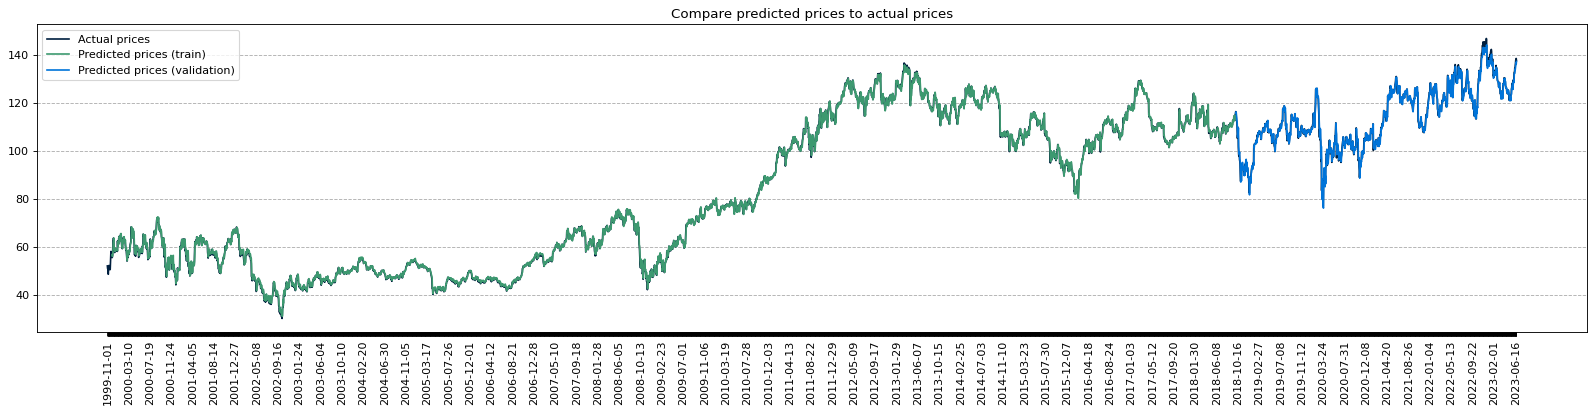

In [ ]:
# plots

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_date, data_close_price, label="Actual prices", color=config["plots"]["color_actual"])
plt.plot(data_date, to_plot_data_y_train_pred, label="Predicted prices (train)", color=config["plots"]["color_pred_train"])
plt.plot(data_date, to_plot_data_y_val_pred, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
plt.title("Compare predicted prices to actual prices")
xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
x = np.arange(0,len(xticks))
plt.xticks(x, xticks, rotation='vertical')
plt.grid(visible=None, which='major', axis='y', linestyle='--')
plt.legend()
plt.show()

 From our results, we can see that the model has managed to learn and predict on both training (green) and validation (blue) datasets very well, as the "Predicted prices" lines significantly overlap with the "Actual prices" values.

Let's zoom into the chart and look closely at the blue "Predicted price (validation)" segment by comparing it against the actual prices values.

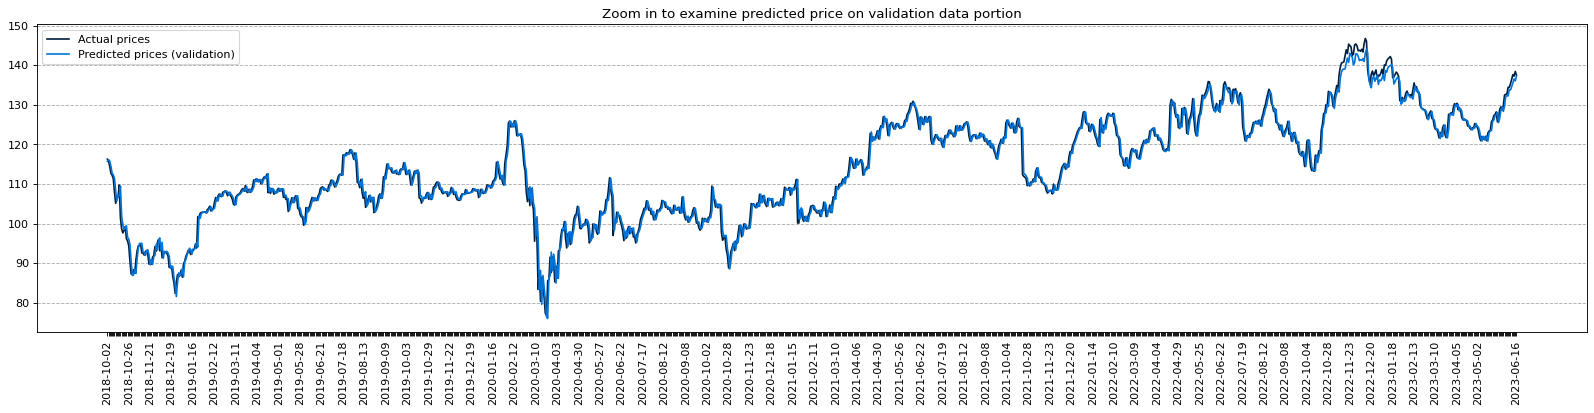

In [ ]:
# prepare data for plotting the zoomed in view of the predicted prices (on validation set) vs. actual prices

to_plot_data_y_val_subset = scaler.inverse_transform(data_y_val)
to_plot_predicted_val = scaler.inverse_transform(predicted_val)
to_plot_data_date = data_date[split_index+config["data"]["window_size"]:]

# plots

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(to_plot_data_date, to_plot_data_y_val_subset, label="Actual prices", color=config["plots"]["color_actual"])
plt.plot(to_plot_data_date, to_plot_predicted_val, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
plt.title("Zoom in to examine predicted price on validation data portion")
xticks = [to_plot_data_date[i] if ((i%int(config["plots"]["xticks_interval"]/5)==0 and (len(to_plot_data_date)-i) > config["plots"]["xticks_interval"]/6) or i==len(to_plot_data_date)-1) else None for i in range(len(to_plot_data_date))] # make x ticks nice
xs = np.arange(0,len(xticks))
plt.xticks(xs, xticks, rotation='vertical')
plt.grid(visible=None, which='major', axis='y', linestyle='--')
plt.legend()
plt.show()

**Predicting Future Stock Prices**

By now, we have trained an LSTM model that can (fairly accurately) predict the next day's price based on the past 20 days' close prices. This means we now have a crystal ball in hand! Let's supply the past 20 days' close prices to the model and see what it predicts for the next trading day (i.e., the future!).

In [ ]:
# predict the closing price of the next trading day

model.eval()

x = torch.tensor(data_x_unseen).float().to(config["training"]["device"]).unsqueeze(0).unsqueeze(2) # this is the data type and shape required, [batch, sequence, feature]
prediction = model(x)
prediction = prediction.cpu().detach().numpy()

In [ ]:
# prepare plots

plot_range = 10
to_plot_data_y_val = np.zeros(plot_range)
to_plot_data_y_val_pred = np.zeros(plot_range)
to_plot_data_y_test_pred = np.zeros(plot_range)

to_plot_data_y_val[:plot_range-1] = scaler.inverse_transform(data_y_val)[-plot_range+1:]
to_plot_data_y_val_pred[:plot_range-1] = scaler.inverse_transform(predicted_val)[-plot_range+1:]

to_plot_data_y_test_pred[plot_range-1] = scaler.inverse_transform(prediction)

to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)
to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)
to_plot_data_y_test_pred = np.where(to_plot_data_y_test_pred == 0, None, to_plot_data_y_test_pred)

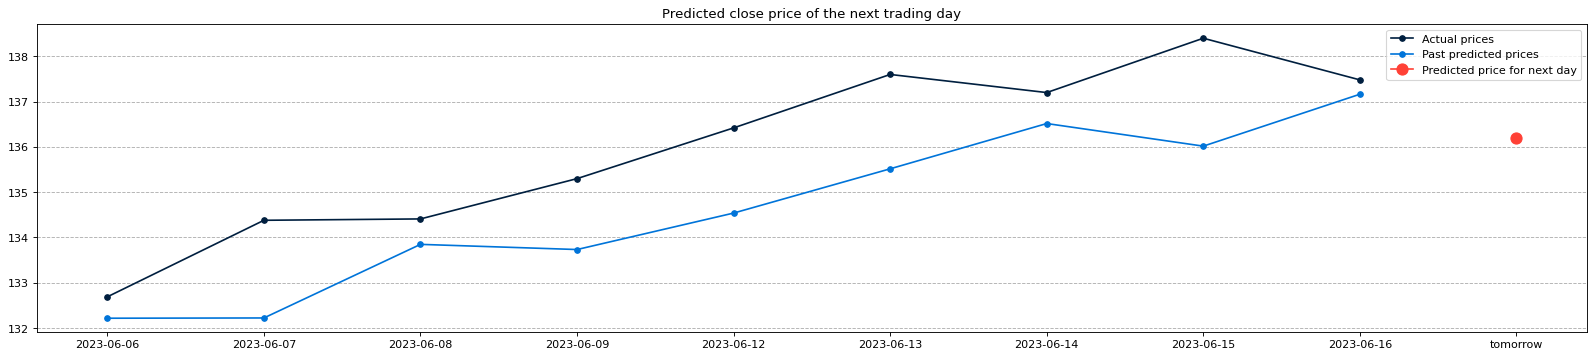

Predicted close price of the next trading day: 136.2


In [ ]:
# plot

plot_date_test = data_date[-plot_range+1:]
plot_date_test.append("tomorrow")

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(plot_date_test, to_plot_data_y_val, label="Actual prices", marker=".", markersize=10, color=config["plots"]["color_actual"])
plt.plot(plot_date_test, to_plot_data_y_val_pred, label="Past predicted prices", marker=".", markersize=10, color=config["plots"]["color_pred_val"])
plt.plot(plot_date_test, to_plot_data_y_test_pred, label="Predicted price for next day", marker=".", markersize=20, color=config["plots"]["color_pred_test"])
plt.title("Predicted close price of the next trading day")
plt.grid(visible=None, which='major', axis='y', linestyle='--')
plt.legend()
plt.show()

print("Predicted close price of the next trading day:", round(to_plot_data_y_test_pred[plot_range-1], 2))